<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/FINAL%202_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course AH2174/FAH3002 - Traffic Simulation Modeling and Applications   
Project 2 - 2.1  
Author: Pengnan Chi  
Date: 11.24.2024


### Task: Implement the IDM (Intelligent Driver Model)

In this section, you will implement the IDM, which is a widely used car-following model.

#### Implementation Steps:
1. Define the IDM parameters.
2. Implement a function to calculate $s^*$.
3. Implement a function to calculate the acceleration $a(t)$.
4. Simulate the car-following behavior using IDM.

#### Instructions:
- Follow the provided structure to fill in the required code.
- Ensure your code is efficient and well-documented.

Below, the areas marked with `# YOU CODE HERE` indicate where you need to add your implementation.


In [12]:
import numpy as np
import matplotlib.pyplot as plt

class Car():
    """
    Represents a single car in the platoon with its speed and displacement states.
    """
    def __init__(self, initSpeed, initDisplacement, id=0):
        """
        Initializes a car with its initial speed and displacement.
        """
        self.speed = [initSpeed]  # Speed history of the car
        self.displacement = [initDisplacement]  # Displacement history of the car
        self.name = id  # Unique ID of the car

    def currState(self):
        """
        Returns the current speed and displacement of the car.
        """
        return self.speed[-1], self.displacement[-1]

    def prevState(self):
        """
        Returns the previous speed and displacement of the car.
        Ensure that at least one previous state exists.
        """
        assert len(self.speed) >= 2, "No previous state available."
        return self.speed[-2], self.displacement[-2]

    def updateState(self, s, d):
        """
        Updates the current state (speed and displacement) of the car.
        """
        self.speed.append(s)
        self.displacement.append(d)


class IntelligentDriverModel():
    """
    Simulates a platoon of cars using the Intelligent Driver Model (IDM).
    """
    def __init__(self, nCars=8):
        """
        Initializes the platoon with nCars.
        Cars are evenly spaced initially, with speed 0.
        """
        self.n = nCars
        self.L = 5.0  # vehicle length for correct bumper-to-bumper spacing
        self.platoon = [
            Car(initSpeed=0, initDisplacement=(nCars-i-1)*10, id=i) for i in range(nCars)
        ]

    def setParam(self, desiredSpeed, timeGap, minGap, accExp, acc, dec, randomTimeGap):
        """
        Sets the parameters for the IDM model.

        Parameters:
        - desiredSpeed: Desired speed (v0) in m/s.
        - timeGap: Safe time headway (T) in seconds.
        - minGap: Minimum safe gap (s0) in meters.
        - accExp: Acceleration exponent (delta).
        - acc: Maximum acceleration (a) in m/s².
        - dec: Comfortable deceleration (b) in m/s².
        - randomTimeGap: Boolean indicating whether to use random time gaps.
        """
        ####################################################################
        #  YOU CODE HERE: Store the parameters as class attributes.
        self.v0 = desiredSpeed
        self.T = timeGap
        self.s0 = minGap
        self.delta = accExp
        self.a = acc
        self.b = dec
        self.randomTimeGap = randomTimeGap
        ####################################################################

    def calcDesiredGap(self, v, vLeading):
        """
        Calculates the desired minimum gap (s*) for the IDM model.

        Parameters:
        - v: Current speed of the car (m/s).
        - vLeading: Speed of the leading car (m/s).

        Returns:
        - sStar: Desired minimum gap (m).
        """
        ####################################################################
        #  YOU CODE HERE: Implement the desired gap formula.
        #  Hint: Use self.s0, self.T, v, vLeading, self.a, self.b
        delta_v = v - vLeading  # relative speed (approaching rate)
        sStar = self.s0 + v * self.T + (v * delta_v) / (2 * (self.a * self.b) ** 0.5)
        ####################################################################
        return sStar

    def calcAcceleration(self, v, s, sStar):
        """
        Calculates the acceleration for the IDM model.

        Parameters:
        - v: Current speed of the car (m/s).
        - s: Current gap to the leading car (m).
        - sStar: Desired minimum gap (m).

        Returns:
        - acceleration: Calculated acceleration (m/s²).
        """
        ####################################################################
        #  YOU CODE HERE: Implement the IDM acceleration formula.
        #  Hint: Use self.v0, self.delta, v, s, sStar
        s_eff = max(0.1, s)  # avoid division-by-zero
        acceleration = self.a * (
            1 - (v / self.v0) ** self.delta - (sStar / s_eff) ** 2
        )
        ####################################################################
        return acceleration

    def stimulate(self, granularity=0.1, totalTime=50):
        """
        Simulates the behavior of the platoon under three scenarios:
        - Acceleration
        - Normal driving
        - Deceleration

        Parameters:
        - granularity: Time step for the simulation (s).
        """
        ####################################################################
        #  YOU CODE HERE: Implement the stimulation logic.
        #  Use the methods above to calculate acceleration, safe speed,
        #  and update the state of each car in the platoon.
        nSteps = int(totalTime / granularity)

        # Leader acceleration profile (fixed to match realistic scenario)
        def leader_accel(t):
            if t < totalTime / 3:
                return self.a
            elif t < 2 * totalTime / 3:
                return 0.0
            else:
                return -self.b

        t = 0.0
        print("Running continuous IDM simulation (accel → cruise → brake)...")

        for step in range(nSteps):
            # ---- Leader update ----
            v0, x0 = self.platoon[0].currState()
            a0 = leader_accel(t)
            new_v0 = max(v0 + a0 * granularity, 0)
            new_x0 = x0 + new_v0 * granularity
            self.platoon[0].updateState(new_v0, new_x0)

            # ---- Followers update ----
            for i in range(1, self.n):
                v, x = self.platoon[i].currState()
                v_lead, x_lead = self.platoon[i - 1].currState()

                # bumper-to-bumper gap
                s = (x_lead - self.L) - x

                # IDM
                sStar = self.calcDesiredGap(v, v_lead)
                acc = self.calcAcceleration(v, s, sStar)

                new_v = max(v + acc * granularity, 0)
                new_x = x + new_v * granularity
                self.platoon[i].updateState(new_v, new_x)

            t += granularity
        ####################################################################
pass

# highway

In [13]:
idm = IntelligentDriverModel()
param = {
     'desiredSpeed': 33.3,
     'timeGap': 1,
     'minGap': 2,
     'accExp': 4,
     'acc': 1,
     'dec':1.5,
     'randomTimeGap':False
}
idm.setParam(**param)

In [14]:
idm.stimulate(0.001)

Running continuous IDM simulation (accel → cruise → brake)...


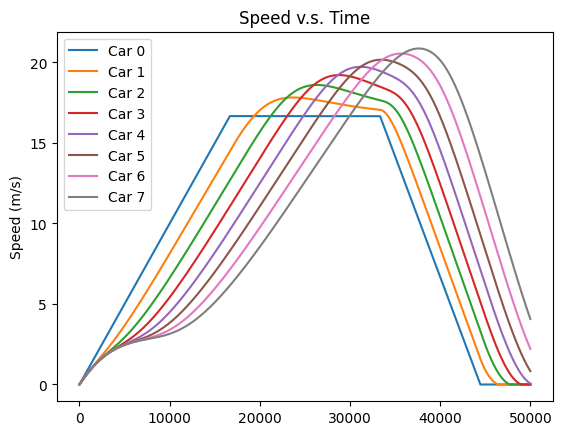

In [15]:
for car in idm.platoon:
    plt.plot(car.speed, label=f"Car {car.name}")

plt.title("Speed v.s. Time")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.show()

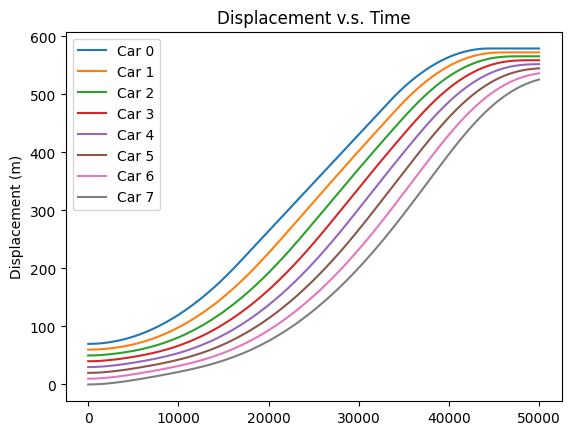

In [16]:
for car in idm.platoon:
    plt.plot(car.displacement, label=f"Car {car.name}")

plt.title("Displacement v.s. Time")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


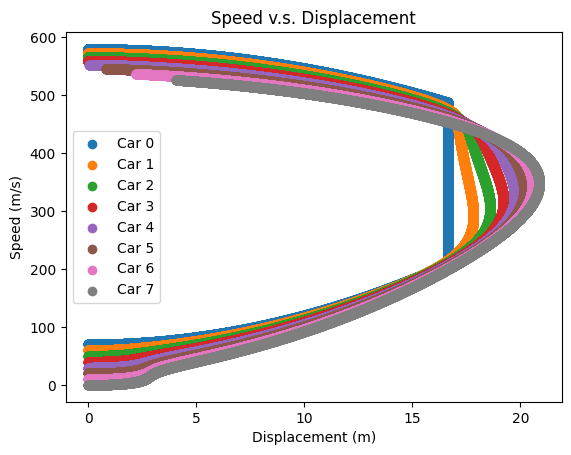

In [17]:
for car in idm.platoon:
    plt.scatter(car.speed, car.displacement, label=f"Car {car.name}")

plt.title("Speed v.s. Displacement")
plt.ylabel("Speed (m/s)")
plt.xlabel("Displacement (m)")
plt.legend()
plt.show()

# city traffic

In [21]:
idm = IntelligentDriverModel()
param = {
     'desiredSpeed': 15,
     'timeGap': 1,
     'minGap': 2,
     'accExp': 4,
     'acc': 1,
     'dec':1.5,
     'randomTimeGap':False
}
idm.setParam(**param)
idm.stimulate(0.001)

Running continuous IDM simulation (accel → cruise → brake)...


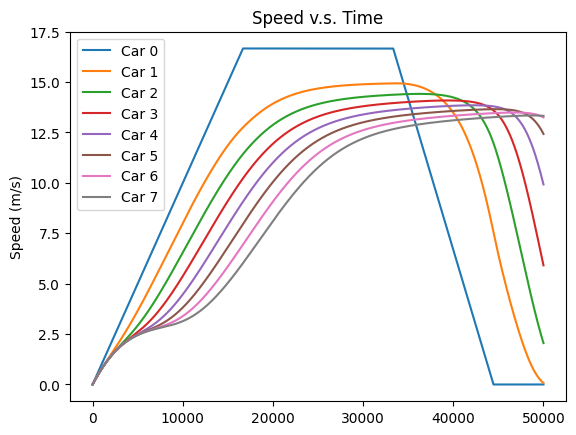

In [19]:
for car in idm.platoon:
    plt.plot(car.speed, label=f"Car {car.name}")

plt.title("Speed v.s. Time")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.show()

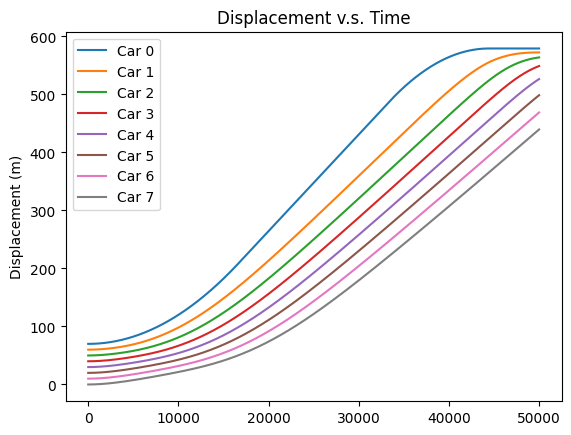

In [20]:
for car in idm.platoon:
    plt.plot(car.displacement, label=f"Car {car.name}")

plt.title("Displacement v.s. Time")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()

# time gap following uniform - highway

In [22]:
idm = IntelligentDriverModel()
param = {
     'desiredSpeed': 33.3333,
     'timeGap': 1,
     'minGap': 2,
     'accExp': 4,
     'acc': 1,
     'dec':1.5,
     'randomTimeGap':True
}
idm.setParam(**param)
idm.stimulate(0.001)

Running continuous IDM simulation (accel → cruise → brake)...


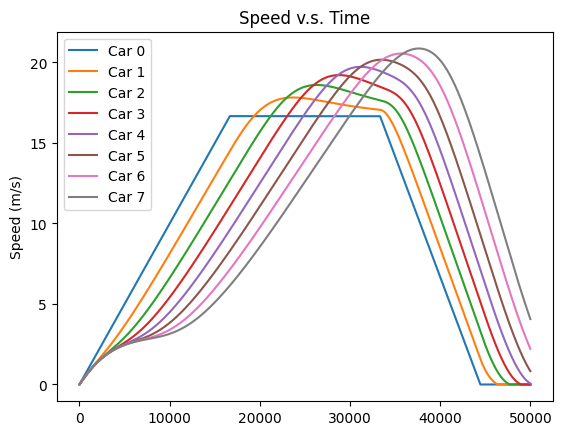

In [23]:
for car in idm.platoon:
    plt.plot(car.speed, label=f"Car {car.name}")

plt.title("Speed v.s. Time")
plt.ylabel("Speed (m/s)")
plt.legend()
plt.show()

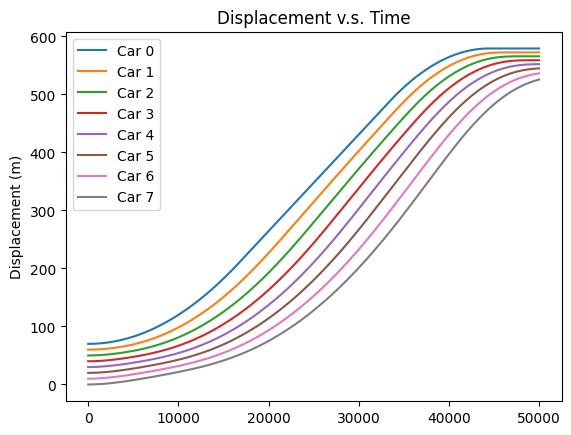

In [24]:
for car in idm.platoon:
    plt.plot(car.displacement, label=f"Car {car.name}")

plt.title("Displacement v.s. Time")
plt.ylabel("Displacement (m)")
plt.legend()
plt.show()